In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from tqdm import tqdm

In [27]:
# Function to create scrollable table within a small window
def create_scrollable_table(df, table_id, title):
    html = f'<h3>{title}</h3>'
    html += f'<div id="{table_id}" style="height:200px; overflow:auto;">'
    html += df.to_html()
    html += '</div>'
    return html

In [28]:
training = pd.read_csv('C:/Users/hangu/Creative Cloud Files/0. Data Science study/Datasets/Optiver -Trading at the close/train.csv')
testing = pd.read_csv('C:/Users/hangu/Creative Cloud Files/0. Data Science study/Datasets/Optiver -Trading at the close/test.csv')
reveal_trg = pd.read_csv('C:/Users/hangu/Creative Cloud Files/0. Data Science study/Datasets/Optiver -Trading at the close/revealed_targets.csv')

testing = testing.drop('currently_scored', axis=1)

# imbalance_size: refers to the difference between the number of shares that buyers are willing to purchase and the number of shares that sellers are willing to sell at a particular price level
# imbalance_buy_sell_flag: 
#       buy-side imbalance: 1 ==> This can create a situation in which buyers are willing to pay more for a stock than sellers are willing to sell it for
#       sell-side imbalance: -1; 
#       no imbalance: 0
# ask_size: represents the number of shares available for purchase at the ask price
# bid_size: represents the number of shares available for sale at the bid price
# matched_size: when buying (bids) and selling (asks) orders match, and a transaction is effected

# ask_price: the lowest price at which sellers will sell stocks
# bid_price: the highest price at which buyes will buy stocks
# reference_price: The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order. 
#                  Can also be thought of as being equal to the near price bounded between the best bid and ask price.
# far_price: The crossing price that will maximize the number of shares matched based on auction interest only. Continuous market orders are excluded.
# near_price: The crossing price that will maximize the number of shares matched based on auction and continuous market orders.
# wap: The weighted average price

# seconds_in_bucket (SIB): represents time bucket in each day, from 0 --> 10 --> ... --> 540, reset as date_id changes
# time_id: represents time bucket, from 0 --> 26454
# row_id: dateID_SIB_stockID

# target: The 60 second future move in the wap of the stock, less the 60 second future move of the synthetic index.
#         The unit of the target is basis points. A 1 basis point price move is equivalent to a 0.01% price move.

In [29]:
training

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [30]:
check = training[training['imbalance_buy_sell_flag']==0]
check['imbalance_size'].value_counts()

imbalance_size
0.0    1131443
Name: count, dtype: int64

In [31]:
training.info()

# Features that supposed to be categories: imbalance_buy_sell_flag

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


In [32]:
train_stat = training.describe().T
scroll_train_stat = create_scrollable_table(train_stat, 'train_stat', 'Summary Statistics (training)')
display(HTML(scroll_train_stat))

,count,mean,std,min,25%,50%,75%,max
stock_id,5237980.0,9.928856e+01,5.787176e+01,0.000000,4.900000e+01,9.900000e+01,1.490000e+02,1.990000e+02
date_id,5237980.0,2.415100e+02,1.385319e+02,0.000000,1.220000e+02,2.420000e+02,3.610000e+02,4.800000e+02
seconds_in_bucket,5237980.0,2.700000e+02,1.587451e+02,0.000000,1.300000e+02,2.700000e+02,4.100000e+02,5.400000e+02
imbalance_size,5237760.0,5.715293e+06,2.051591e+07,0.000000,8.453415e+04,1.113604e+06,4.190951e+06,2.982028e+09
imbalance_buy_sell_flag,5237980.0,-1.189619e-02,8.853374e-01,-1.000000,-1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
reference_price,5237760.0,9.999955e-01,2.532497e-03,0.935285,9.987630e-01,9.999670e-01,1.001174e+00,1.077488e+00
matched_size,5237760.0,4.510025e+07,1.398413e+08,4316.610000,5.279575e+06,1.288264e+07,3.270013e+07,7.713682e+09
far_price,2343638.0,1.001713e+00,7.214705e-01,0.000077,9.963320e-01,9.998830e-01,1.003318e+00,4.379531e+02
near_price,2380800.0,9.996601e-01,1.216920e-02,0.786988,9.971000e-01,9.998890e-01,1.002590e+00,1.309732e+00
bid_price,5237760.0,9.997263e-01,2.499345e-03,0.934915,9.985290e-01,9.997280e-01,1.000905e+00,1.077488e+00


In [33]:
print(len(training['seconds_in_bucket'].unique()))
print(training['seconds_in_bucket'].unique())

training.groupby(['stock_id', 'date_id'])['stock_id'].count()

# Meaning: Stocks data are updated 55 times/day, each time is noted by seconds_in_bucket 0 --> 10 --> 20 --> ... --> 540

55
[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530
 540]


stock_id  date_id
0         0          55
          1          55
          2          55
          3          55
          4          55
                     ..
199       476        55
          477        55
          478        55
          479        55
          480        55
Name: stock_id, Length: 95236, dtype: int64

In [34]:
a = training['date_id'].unique()
b = training.groupby(['stock_id', 'date_id'])['stock_id'].count()[0][0]

print('Number of days: ', len(a))
print('Number of time buckets per day: ', b)
print('Total number of time buckets: ', len(a)*b)

Number of days:  481
Number of time buckets per day:  55
Total number of time buckets:  26455


In [35]:
training['stock_id'].value_counts().sort_values().head(15)

# Those that have values < 26455 doesnot appear in all time buckets.

stock_id
102    10230
135    15950
79     16500
199    21615
153    22605
150    23210
156    24420
69     24420
78     26235
73     26400
99     26400
13     26455
12     26455
11     26455
7      26455
Name: count, dtype: int64

In [36]:
null_count_trn = pd.DataFrame(training.isnull().sum() / training.shape[0] * 100)
null_count_trn.rename(columns={0: 'Missing value percentage'}, inplace=True)
null_count_trn

,Missing value percentage
stock_id,0.000000
date_id,0.000000
seconds_in_bucket,0.000000
imbalance_size,0.004200
imbalance_buy_sell_flag,0.000000
reference_price,0.004200
matched_size,0.004200
far_price,55.256836
near_price,54.547364
bid_price,0.004200


In [37]:
# Drop rows with missing values in 'target' column:
training.dropna(subset=['target'], inplace=True)

null_count_trn = pd.DataFrame(training.isnull().sum() / training.shape[0] * 100)
null_count_trn.rename(columns={0: 'Missing value percentage'}, inplace=True)
null_count_trn

,Missing value percentage
stock_id,0.000000
date_id,0.000000
seconds_in_bucket,0.000000
imbalance_size,0.002520
imbalance_buy_sell_flag,0.000000
reference_price,0.002520
matched_size,0.002520
far_price,55.256084
near_price,54.546600
bid_price,0.002520


In [38]:
testing

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id,row_id
0,0,478,0,3753451.43,-1,0.999875,11548975.43,NaN,NaN,0.999875,22940.00,1.000050,9177.60,1.000000,26290,478_0_0
1,1,478,0,985977.11,-1,1.000245,3850033.97,NaN,NaN,0.999940,1967.90,1.000601,19692.00,1.000000,26290,478_0_1
2,2,478,0,599128.74,1,1.000584,4359198.25,NaN,NaN,0.999918,4488.22,1.000636,34955.12,1.000000,26290,478_0_2
3,3,478,0,2872317.54,-1,0.999802,27129551.64,NaN,NaN,0.999705,16082.04,1.000189,10314.00,1.000000,26290,478_0_3
4,4,478,0,740059.14,-1,0.999886,8880890.78,NaN,NaN,0.999720,19012.35,1.000107,7245.60,1.000000,26290,478_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32995,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,26454,480_540_195
32996,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,26454,480_540_196
32997,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,26454,480_540_197
32998,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,26454,480_540_198


In [39]:
testing.groupby(['stock_id', 'date_id'])['stock_id'].count()

# Meaning: Stocks data are updated 55 times/day, similar to "training" set

stock_id  date_id
0         478        55
          479        55
          480        55
1         478        55
          479        55
                     ..
198       479        55
          480        55
199       478        55
          479        55
          480        55
Name: stock_id, Length: 600, dtype: int64

In [40]:
testing['stock_id'].value_counts().sort_index()

stock_id
0      165
1      165
2      165
3      165
4      165
      ... 
195    165
196    165
197    165
198    165
199    165
Name: count, Length: 200, dtype: int64

In [41]:
testing['date_id'].unique()

array([478, 479, 480], dtype=int64)

In [42]:
null_count_tst = pd.DataFrame(testing.isnull().sum() / testing.shape[0] * 100)
null_count_tst.rename(columns={0: 'Missing value percentage'}, inplace=True)
null_count_tst

,Missing value percentage
stock_id,0.000000
date_id,0.000000
seconds_in_bucket,0.000000
imbalance_size,0.000000
imbalance_buy_sell_flag,0.000000
reference_price,0.000000
matched_size,0.000000
far_price,55.239394
near_price,54.545455
bid_price,0.000000


In [43]:
reveal_trg

,stock_id,date_id,seconds_in_bucket,time_id,revealed_target,revealed_date_id,revealed_time_id
0,0.0,478,0,26290,-2.310276,477.0,26235.0
1,1.0,478,0,26290,-12.850165,477.0,26235.0
2,2.0,478,0,26290,-0.439882,477.0,26235.0
3,3.0,478,0,26290,7.259846,477.0,26235.0
4,4.0,478,0,26290,4.780292,477.0,26235.0
...,...,...,...,...,...,...,...
33157,NaN,480,500,26450,NaN,NaN,NaN
33158,NaN,480,510,26451,NaN,NaN,NaN
33159,NaN,480,520,26452,NaN,NaN,NaN
33160,NaN,480,530,26453,NaN,NaN,NaN


In [44]:
reveal_trg['stock_id'].value_counts().sort_index()

stock_id
0.0      165
1.0      165
2.0      165
3.0      165
4.0      165
        ... 
195.0    165
196.0    165
197.0    165
198.0    165
199.0    165
Name: count, Length: 200, dtype: int64

In [45]:
reveal_trg['date_id'].unique()

array([478, 479, 480], dtype=int64)

In [46]:
# EDA

# Check correlation of "target" and other features:
correlation = training.corr()['target'].sort_values()
correlation

wap                       -0.035165
bid_price                 -0.022326
ask_price                 -0.021674
bid_size                  -0.018000
reference_price           -0.017394
seconds_in_bucket         -0.002203
far_price                 -0.001804
imbalance_size            -0.001190
row_id                    -0.000975
stock_id                   0.000130
matched_size               0.000197
time_id                    0.000889
date_id                    0.000893
near_price                 0.006045
ask_size                   0.014936
imbalance_buy_sell_flag    0.015102
target                     1.000000
Name: target, dtype: float64

<Axes: >

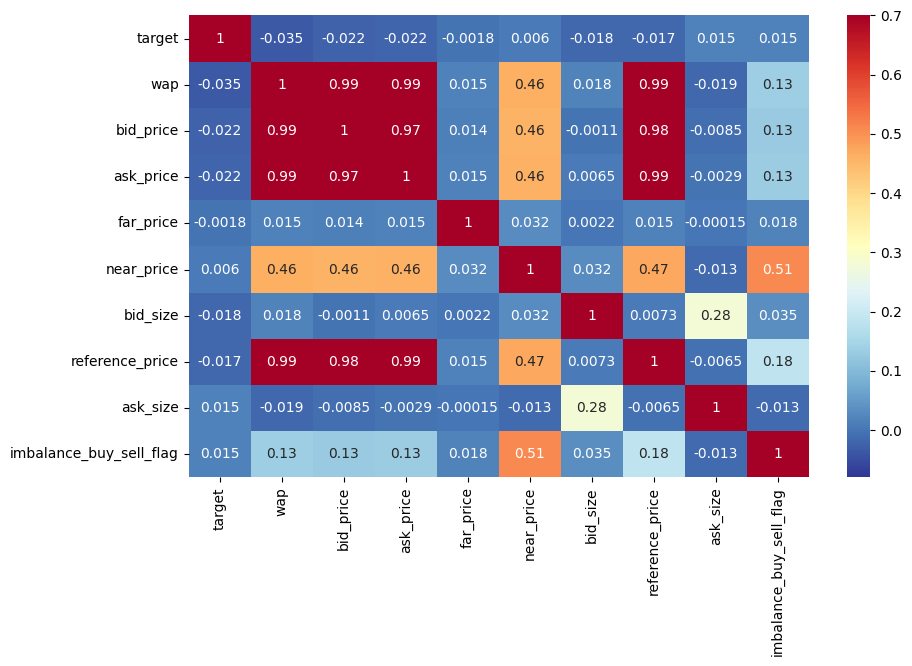

In [61]:
mini_train = training[['target', 'wap', 'bid_price', 'ask_price', 'far_price', 'near_price', 'bid_size', 'reference_price', 'ask_size', 'imbalance_buy_sell_flag']]
mini_train_corr = mini_train.corr()

plt.figure(figsize=(10,6))
sns.heatmap(mini_train_corr, cmap = plt.cm.RdYlBu_r, annot=True, vmax = 0.7, vmin = -0.08)


(-100.0, 100.0)

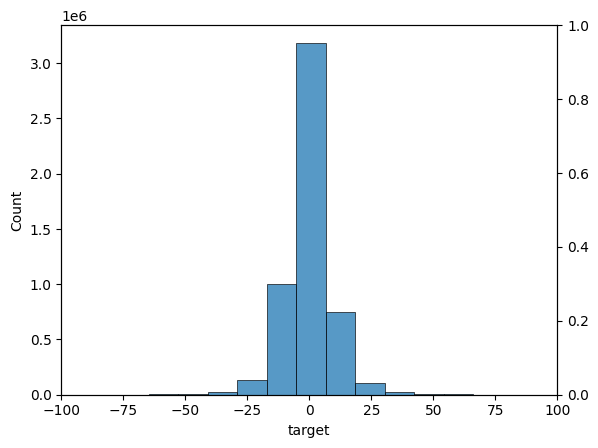

In [55]:
import scipy.stats as stats

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

tgt_hist = sns.histplot(training['target'], bins = 70, ax=ax1)
ax1.set_xlim(-100, 100)


In [74]:
# From the histogram above, most of the values of target is in range [-100, 100]. Let's take a look at the outliers:
outliers = training[(training['target']< -100) | (training['target']>100)]
print(len(outliers), "\n")

correlation_outliers = outliers.corr()['target'].sort_values()
correlation


931 



wap                       -0.035165
bid_price                 -0.022326
ask_price                 -0.021674
bid_size                  -0.018000
reference_price           -0.017394
seconds_in_bucket         -0.002203
far_price                 -0.001804
imbalance_size            -0.001190
row_id                    -0.000975
stock_id                   0.000130
matched_size               0.000197
time_id                    0.000889
date_id                    0.000893
near_price                 0.006045
ask_size                   0.014936
imbalance_buy_sell_flag    0.015102
target                     1.000000
Name: target, dtype: float64

In [107]:
outliers['far_price'].sort_values(ascending=False)

2728113    1.144621
2182998    1.097288
1029930    1.094688
4399073    1.092063
4399473    1.092063
             ...   
5182811         NaN
5220969         NaN
5221169         NaN
5221369         NaN
5221569         NaN
Name: far_price, Length: 931, dtype: float64

In [108]:
training['far_price'].sort_values(ascending=False)

134979     437.95310
891618     424.11658
891814     424.11658
1649475    309.02426
1648884    309.02426
             ...    
5236124          NaN
5236151          NaN
5236167          NaN
5236240          NaN
5236351          NaN
Name: far_price, Length: 5237892, dtype: float64

<Axes: >

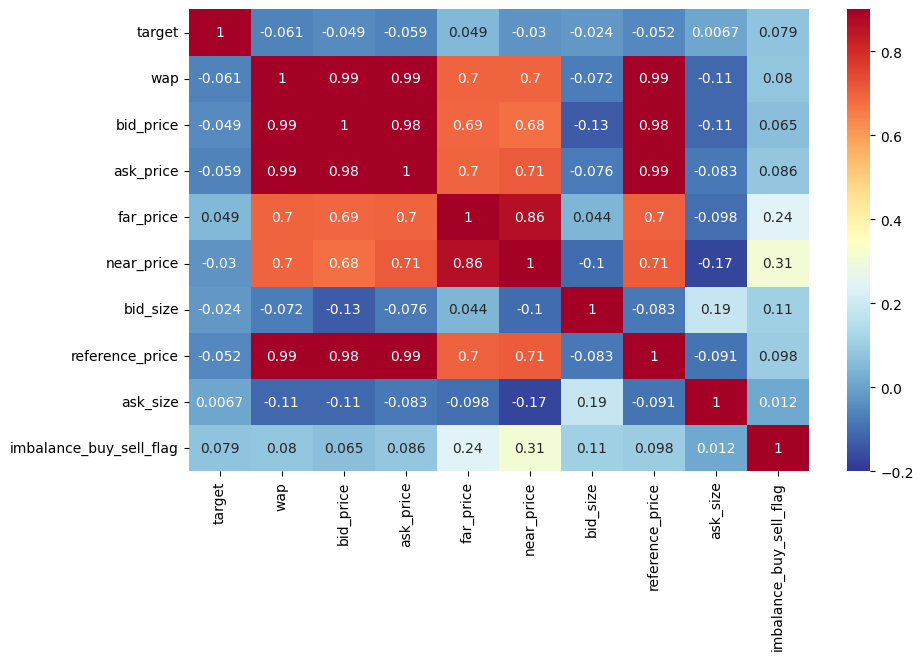

In [66]:
mini_outliers = outliers[['target', 'wap', 'bid_price', 'ask_price', 'far_price', 'near_price', 'bid_size', 'reference_price', 'ask_size', 'imbalance_buy_sell_flag']]
mini_outliers_corr = mini_outliers.corr()

plt.figure(figsize=(10,6))
sns.heatmap(mini_outliers_corr, cmap = plt.cm.RdYlBu_r, annot=True, vmax = 0.9, vmin = -0.2)

# For outliers, the importance of "far_price" and "near_price" increases significantly. 
# The reason could be that in "training" set, some of "far_price" have very high values (>300).

2342807
831


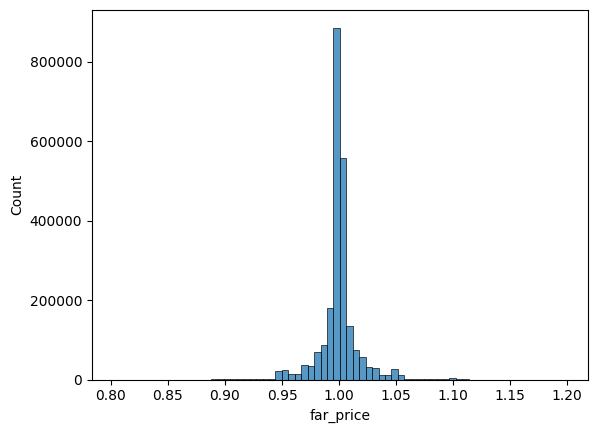

In [94]:
most_far_train = training[(training['far_price'] < 1.2) & (training['far_price'] > 0.8)]
print(len(most_far_train)) 
print(len(training[~training['far_price'].isnull()]) - len(most_far_train))

fig, ax1 = plt.subplots()
train_far_hist = sns.histplot(most_far_train['far_price'], bins = 70, ax=ax1)

# Most of the values hover in the range [0.8, 1.2]


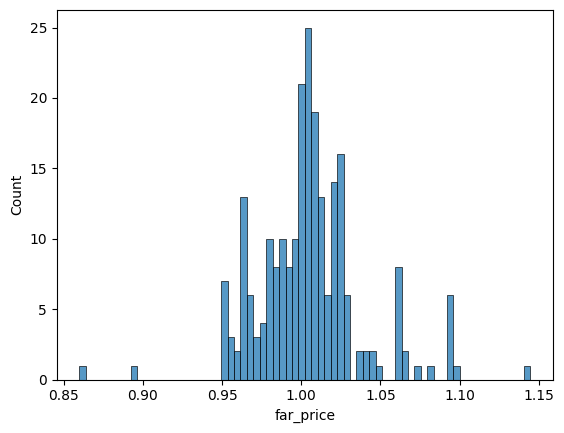

In [67]:
fig, ax1 = plt.subplots()
out_far_hist = sns.histplot(outliers['far_price'], bins = 70, ax=ax1)

# All of the values hover in the range [0.85, 1.15]


2380498
302


<Axes: xlabel='near_price', ylabel='Count'>

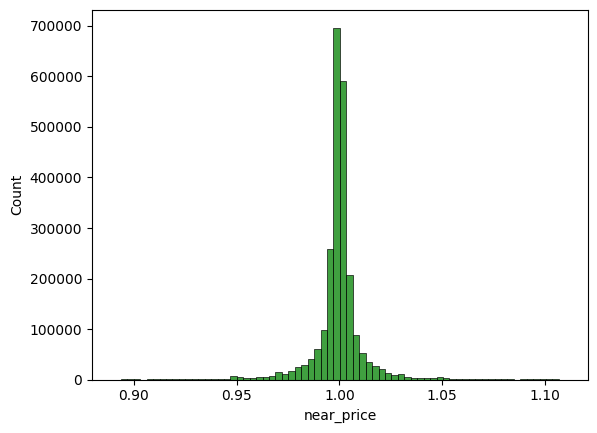

In [103]:
# How about near_price?

most_near_train = training[(training['near_price'] < 1.11) & (training['near_price'] > 0.89)]
print(len(most_near_train)) 
print(len(training[~training['near_price'].isnull()]) - len(most_near_train))

fig, ax1 = plt.subplots()
sns.histplot(most_near_train['near_price'], bins = 70, color='green', ax=ax1)

# Most of the values hover in the range [0.89, 1.11]


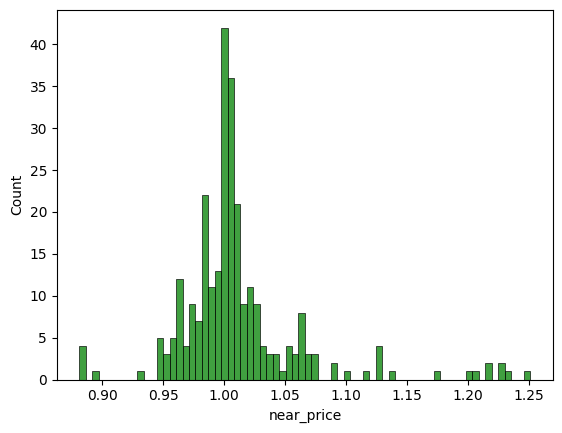

In [104]:
fig, ax1 = plt.subplots()
out_far_hist = sns.histplot(outliers['near_price'], bins = 70, color='green', ax=ax1)

# All of the values hover in the range [0.85, 1.25]

In [50]:
# Feature engineering:

# |ask_size - bid_size|: When there is a significant difference between these two sizes, it can indicate an imbalance in the market.
# spread = ask_price - bid_price. When the spread is "narrow", it typically means that there is ample liquidity in the security. This situation can be helpful for investors because it makes it easier to enter or exit their positions, particularly in the case of large positions.
